In [1]:
from sqlalchemy import create_engine
import pandas as pd
from datetime import date, datetime

## Using SQLAlchemy to load the data and make main data frames

In [2]:
engine = create_engine("sqlite:///data/mta.db")

In [3]:
#These will be the main data frames used for work in Pandas
all_data_mta = pd.read_sql('SELECT * FROM mta_data;', engine)
all_data_weather = pd.read_sql('SELECT * FROM weather;', engine)

## Data cleaning, querying, and manipulation

In [4]:
#drop unneeded columns from mta data
all_data_mta.drop(['DESC', 'EXITS'], axis=1, inplace=True)

In [5]:
#rename columns in mta data
all_data_mta.rename(columns = {
    'CA' : 'ca',
    'UNIT' : 'unit',
    'SCP' : 'scp',
    'STATION' : 'station',
    'LINENAME' : 'linename',
    'DIVISION' : 'division',
    'DATE' : 'date',
    'TIME' : 'time',
    'ENTRIES' : 'entries'
}, inplace=True)

In [6]:
#Create a new column for date_time (only for mta data, weather data is only measured daily).
all_data_mta["date_time"] = pd.to_datetime(all_data_mta['date'] + " " + all_data_mta['time'], 
                                            format="%m/%d/%Y %H:%M:%S")
    
#Drop the time column now that we have date_time
all_data_mta.drop(['time'], axis=1, inplace=True)

#Make date a datetime64 type
all_data_mta['date'] = pd.to_datetime(all_data_mta.date, format="%m/%d/%Y")
all_data_weather['date'] = pd.to_datetime(all_data_weather.date, format="%d-%m-%Y")

In [7]:
#Delete all of the data outside the date range of interest: 12/31/2015 to 6/30/2016 (both dataframes)

start = pd.to_datetime('12/31/2015', format="%m/%d/%Y")
end = pd.to_datetime('6/30/2016', format="%m/%d/%Y")
observation_period = pd.date_range(start, end)

all_data_mta = all_data_mta[all_data_mta['date'].isin(observation_period)]
all_data_weather = all_data_weather[all_data_weather['date'].isin(observation_period)]

In [8]:
#Removing duplicates from mta data
all_data_mta.sort_values(['ca', 'unit', 'scp', 'station', 'date_time'], 
                          inplace=True, ascending=False)
all_data_mta.drop_duplicates(subset=['ca', 'unit', 'scp', 'station', 'date_time'], inplace=True)

In [9]:
turnstiles_daily = (all_data_mta
                        .groupby(['ca', 'unit', 'scp', 'station', 'date'],as_index=False)
                        .entries.first())

In [10]:
#First step in creating the daily_entries column
turnstiles_daily[['prev_date', 'prev_entries']] = (turnstiles_daily
                                                           .groupby(['ca', 'unit', 'scp', 'station'])[["date", 'entries']]
                                                           .apply(lambda grp: grp.shift(1)))
turnstiles_daily.dropna(subset=['prev_date'], axis=0, inplace=True)

In [11]:
'''To create the daily entries column the function needs to tag errors uch as:
        -If entries are negative
        -If count is very large
        
        CONSIDER CHANGING THIS FUNCTION because max_counter is a magic number. ALSO we are making a big
        assumption that negative entries means we should reverse the counter.
        '''

def get_daily_counts(row, max_counter):
    counter = row['entries'] - row['prev_entries']
    if counter < 0:
        #Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        #Maybe counter was reset to zero?
        counter = min(row['entries'], row['prev_entries'])
    if counter > max_counter:
        #Check again that it is still not a huge number
        return 0
    return counter


In [12]:
turnstiles_daily['daily_entries'] = turnstiles_daily.apply(get_daily_counts,
                                                                          axis=1,
                                                                          max_counter = 1000000)

In [13]:
daily_turnstiles_station = turnstiles_daily.groupby(['station', 'date'])[['daily_entries']].sum().reset_index()

In [14]:
#Replace all instances of 'T' with small numerical value
#'T' represents trace amounts and occurs in 'precipitation', 'snowfall', 'snow_depth' columns

all_data_weather = all_data_weather.replace(['T'], 0.25)

#Converting the dtype to float64 (from object)    
all_data_weather = all_data_weather.astype({'precipitation' : 'float64',
                                                 'snowfall' : 'float64',
                                                 'snow_depth' : 'float64'})

In [15]:
def merge_weather_data(mta_df):
    '''Joins the weather table to whatever mta data you are working on (on the key of date)
    mta_df: DataFrame of whatever mta data you want to work with'''
    mta_df = mta_df.join(all_data_weather.set_index('date'), on='date')
    mta_df.reset_index()
    return mta_df

In [16]:
daily_turnstiles_station = merge_weather_data(daily_turnstiles_station)

In [17]:
#Create day of the week column in mta data
daily_turnstiles_station['day_of_week'] = daily_turnstiles_station['date'].dt.day_name()


In [18]:
#Data Frame to look at only weekend days
weekend_turnstiles = daily_turnstiles_station[(daily_turnstiles_station['day_of_week'] == 'Saturday') |
                                              (daily_turnstiles_station['day_of_week'] == 'Sunday')].copy()

---
# Set up for exploratory data analysis

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy import stats

### Functions for adding regression metrics

In [20]:
#### Doing all analysis on avg_temp right now because that seems to be easiest

def get_mean_daily_entries(row, all_data):
    return (add_regression_metric(row, all_data, 'mean_daily_entries'))

def get_std_daily_entries(row, all_data):
    return (add_regression_metric(row, all_data, 'std_daily_entries'))

def get_r_sq(row, all_data):
    return (add_regression_metric(row, all_data, 'r_sq'))

def get_slope(row, all_data):
    return (add_regression_metric(row, all_data, 'slope'))
    
def get_std_err(row, all_data):
    return (add_regression_metric(row, all_data, 'std_err'))


def add_regression_metric(row, all_data, statistic):
    '''
    This function should be applied to a data frame that is grouped by station.
    all_data: Dataframe that should reflect daily entries for all stations for the Observation Period.
    '''

    station = row['station']
    
    #Makes a sub df that has all the data from just that one station (daily entires for one specific station)
    mask = all_data['station'] == station
    individual_station_df = all_data[mask]
        
    #Assign x and y alues to columns of the sub data frame
    x_values = individual_station_df['avg_temp']
    y_values = individual_station_df['daily_entries']
        
    #get regression statistics from data
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
    r_sq = r_value**2
    
    mean_daily_entries = y_values.mean()
    std_daily_entries = y_values.std()
    
    #These statements are for the functions above so that we can run this function for a certain metric
    if statistic == 'mean_daily_entries':
        return mean_daily_entries
    elif statistic == 'std':
        return std_daily_entries
    elif statistic == 'r_sq':
        return r_sq
    elif statistic == 'slope':
        return slope
    elif statistic == 'std_err':
        return std_err

 ### Function for quickly plotting a station

In [21]:
def scatter_plot_station(df, variable, station_name):
    '''Plot some variable for a specific station name
    
    variable: input column name as string
    station_name: input station name as string
    '''
    station = df[df['station'] == station_name]
    plt.scatter(station[variable], station['daily_entries'])
    plt.title(station_name)
    plt.xlabel(variable)
    plt.ylabel('daily entries')
    
    return plt.show()

## Adding columns and calculating the change in entries and avg_temp from the day one week prior

In [22]:
weekend_turnstiles.sort_values(['station', 'date'], inplace = True)

In [23]:
weekend_turnstiles[['week_ago_temp', 'week_ago_entries']] = (weekend_turnstiles
                                                           .groupby(['station'])[['avg_temp', 'daily_entries']]
                                                           .apply(lambda grp: grp.shift(2)))

weekend_turnstiles.dropna(subset=['week_ago_entries'], axis=0, inplace=True)

weekend_turnstiles['week_pct_chg_temp'] = (weekend_turnstiles['avg_temp'] / weekend_turnstiles['week_ago_temp'] - 1) * 100
weekend_turnstiles['week_pct_chg_entries'] = (weekend_turnstiles['daily_entries'] / weekend_turnstiles['week_ago_entries'] - 1) * 100

### Creating table of each station and it's regression figures (x = avg_temp, y = entries)

In [24]:
# Data frame for total entries for the entire Observation period by station
# We can use this to see the busiest staions
station_totals_weekend = weekend_turnstiles.groupby('station').sum()\
    .sort_values('daily_entries', ascending=False)\
    .reset_index()

#Dropping the columns that would be meaningless in this aggregation
station_totals_weekend.drop(['max_temp', 'min_temp', 'avg_temp', 'precipitation', 'snowfall', 'snow_depth'],
                            axis = 1,
                            inplace = True)

In [25]:
#Adding some regression statistics columns to the station

station_totals_weekend[['std_daily_entries']] = station_totals_weekend.apply(get_mean_daily_entries,
                                                                          axis=1,
                                                                          all_data = weekend_turnstiles)

station_totals_weekend[['mean_daily_entries']] = station_totals_weekend.apply(get_mean_daily_entries,
                                                                          axis=1,
                                                                          all_data = weekend_turnstiles)

station_totals_weekend[['r_sq']] = station_totals_weekend.apply(get_r_sq,
                                                                          axis=1,
                                                                          all_data = weekend_turnstiles)
station_totals_weekend[['slope']] = station_totals_weekend.apply(get_slope,
                                                                          axis=1,
                                                                          all_data = weekend_turnstiles)

station_totals_weekend[['std_err']] = station_totals_weekend.apply(get_std_err,
                                                                          axis=1,
                                                                        all_data = weekend_turnstiles)


# Exploratory Data Analysis

## Let's explore stations with the highest R squared between avg_temp and entries

In [26]:
# Top ten stations ordered by R squared as calculated x = avg_temp and y = daily entries

station_totals_weekend.sort_values('r_sq' ,ascending = False).iloc[0:10]

,station,daily_entries,week_ago_temp,week_ago_entries,week_pct_chg_temp,week_pct_chg_entries,std_daily_entries,mean_daily_entries,r_sq,slope,std_err
364,ROCKAWAY PARK B,23240.0,2479.0,20987.0,933.424986,1838.347664,464.80,464.80,0.550313,14.967191,1.952857
155,BRIGHTON BEACH,308932.0,2479.0,299843.0,933.424986,3496.013420,6178.64,6178.64,0.546463,81.734058,10.747516
73,CONEY IS-STILLW,617418.0,2479.0,575670.0,933.424986,840.007395,12348.36,12348.36,0.538357,352.051892,47.054853
338,80 ST,65079.0,2479.0,60600.0,933.424986,73616.202480,1301.58,1301.58,0.520915,35.366309,4.895442
314,OCEAN PKWY,86310.0,2479.0,84489.0,933.424986,3639.806404,1726.20,1726.20,0.513492,21.064222,2.959397
357,BEACH 90 ST,34897.0,2479.0,30213.0,933.424986,2684.455733,697.94,697.94,0.510438,30.830943,4.358113
369,BEACH 98 ST,19477.0,2479.0,16476.0,933.424986,3165.781981,389.54,389.54,0.473677,19.726894,3.001393
234,HOWARD BCH JFK,167054.0,2479.0,164296.0,933.424986,1177.839730,3341.08,3341.08,0.469153,35.588515,5.464081
372,BEACH 105 ST,7294.0,2479.0,6008.0,933.424986,3172.507637,145.88,145.88,0.461856,7.735513,1.205214
332,W 8 ST-AQUARIUM,73011.0,2479.0,67969.0,933.424986,872.700310,1460.22,1460.22,0.452065,49.582732,7.879046


## Setting a data frame of a few stations to focus on when graphing

In [27]:
# We want to start by focusing on stations that have decently stong relationships between avg_temp and
# ridership and also have decently high levels of traffic.

stations_of_interest_mask = ((station_totals_weekend['r_sq'] > 0.4) &
                      (station_totals_weekend['daily_entries'] > 10000))

stations_of_interest = station_totals_weekend[stations_of_interest_mask]

#Another way to possible look at things...

#mask = (station_totals_weekend['station'].str.contains('BEACH'))
#stations_of_interest = station_totals_weekend[mask]

## Graphing stations_of_interest and examining avg_temp and entries along with entries throughout the time period

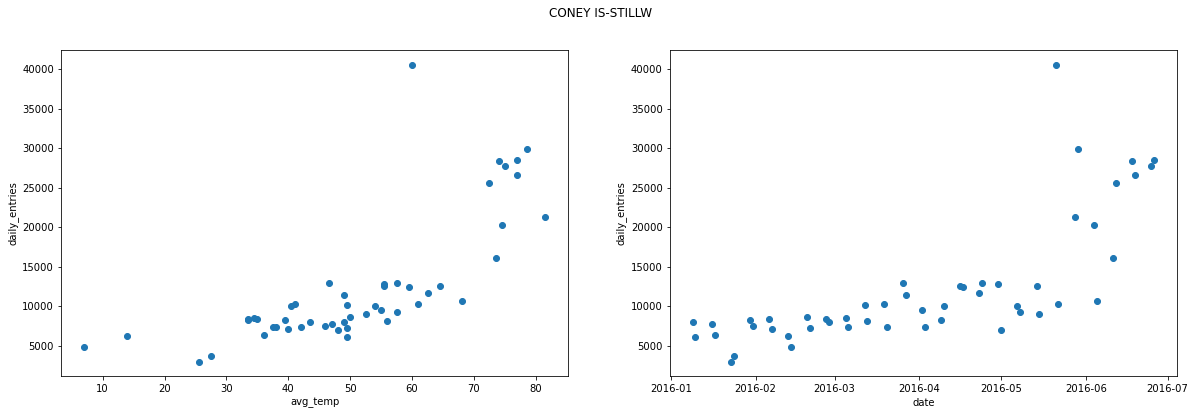

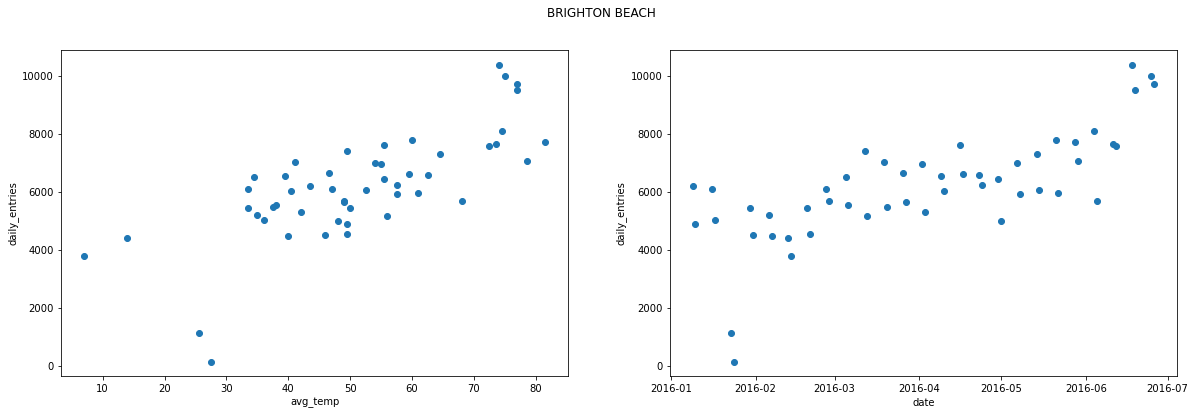

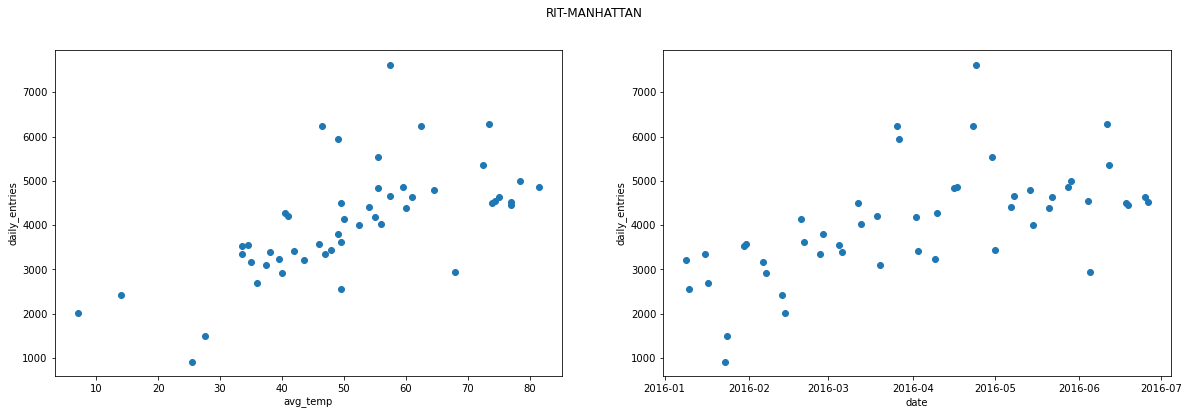

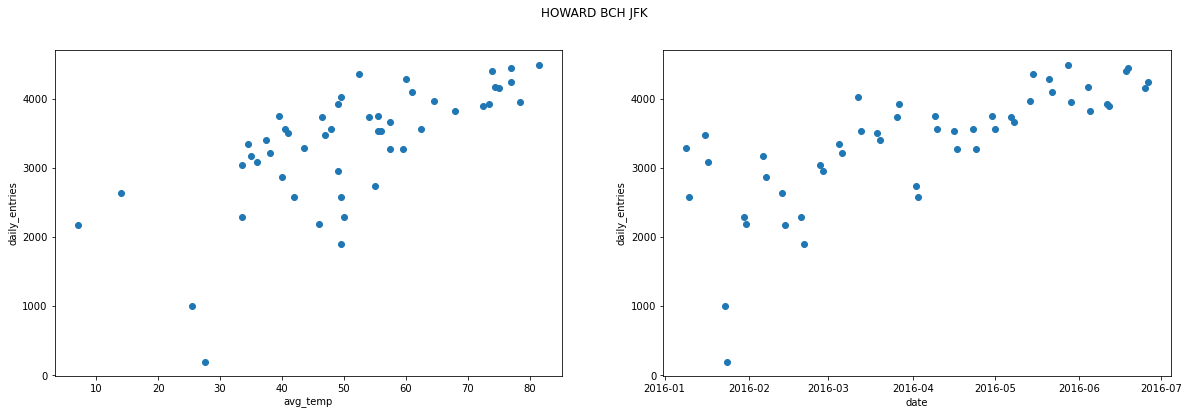

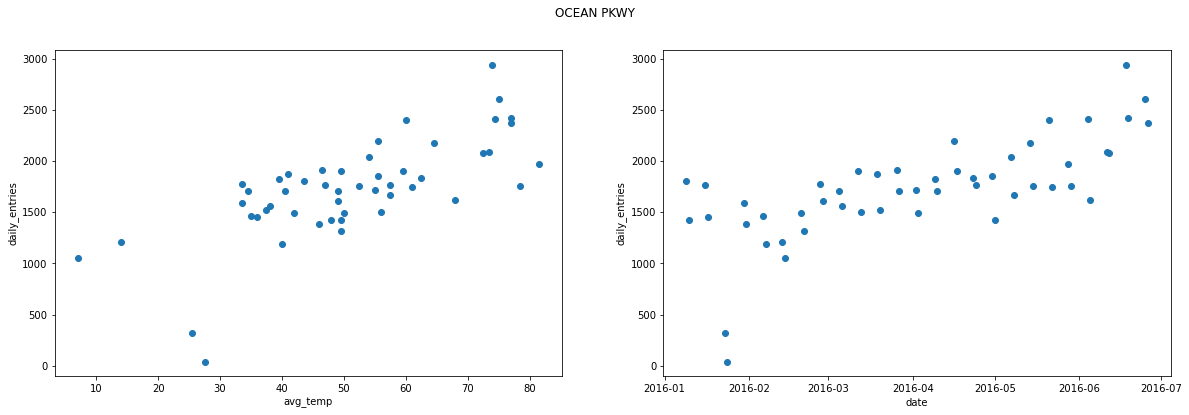

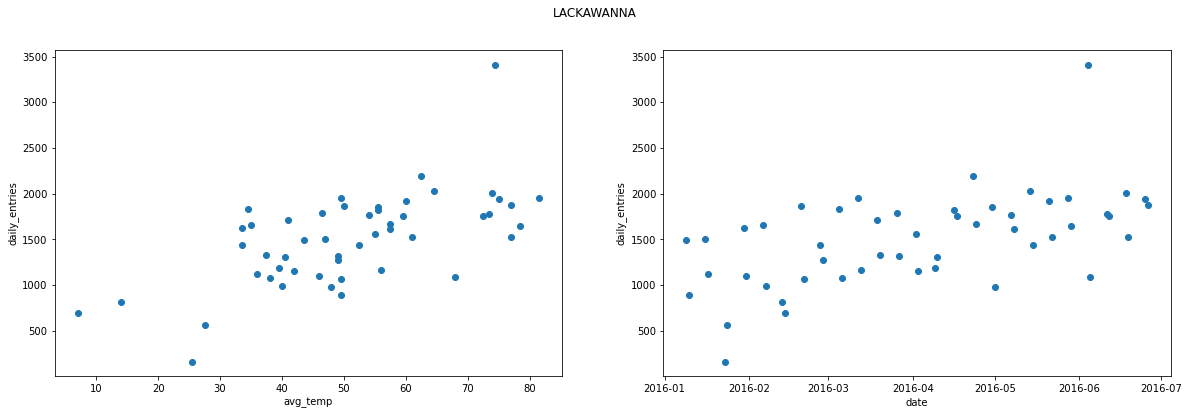

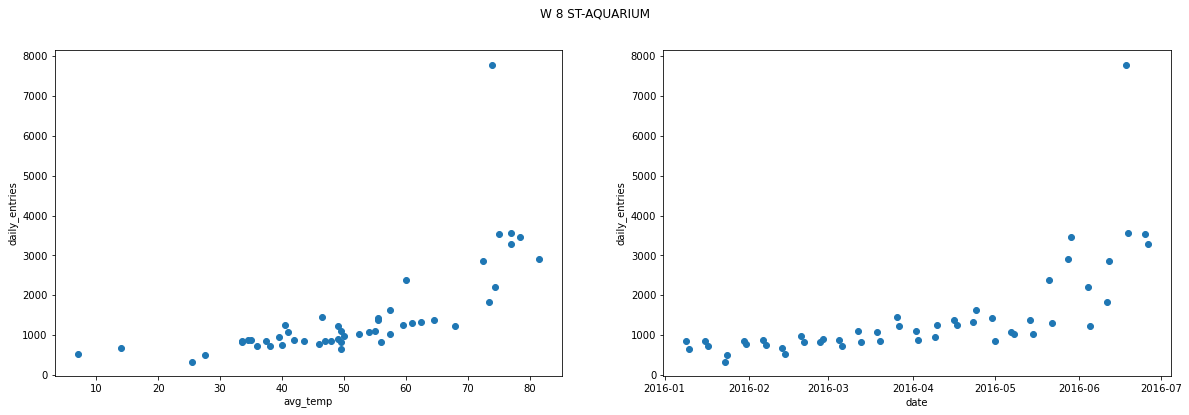

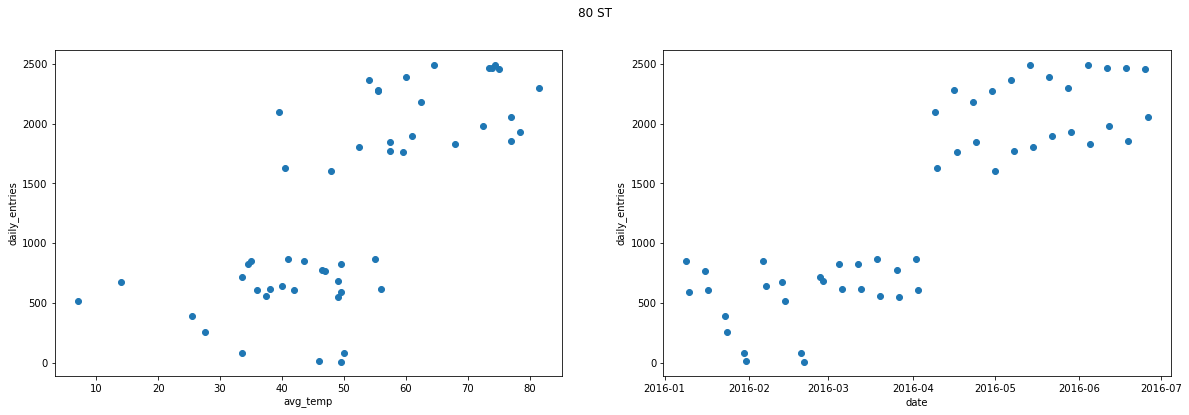

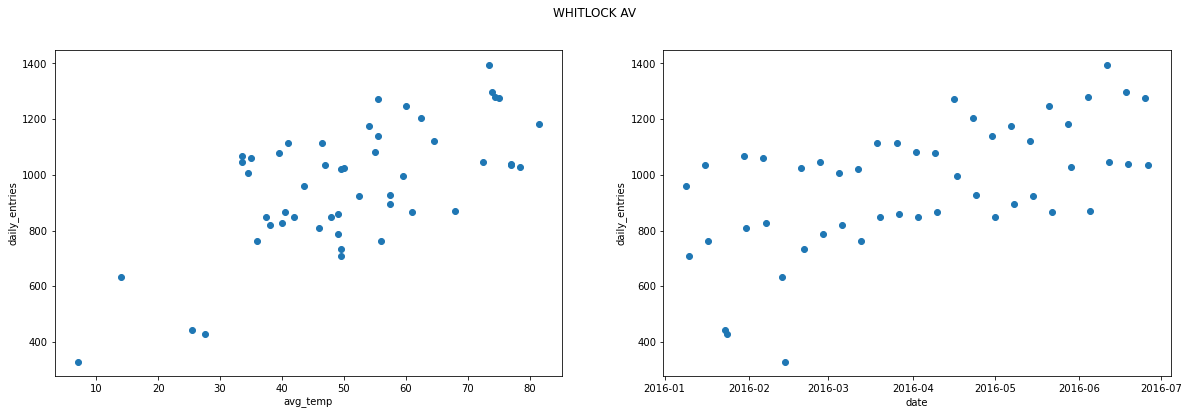

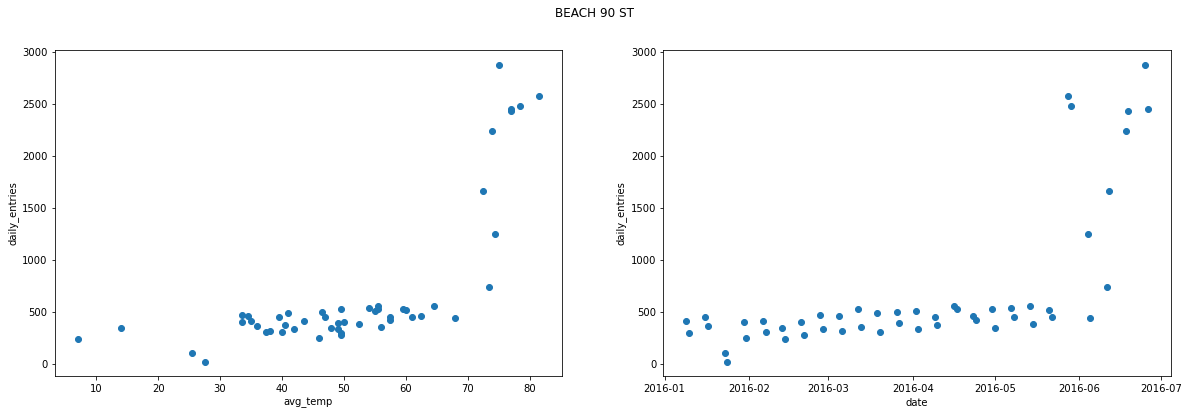

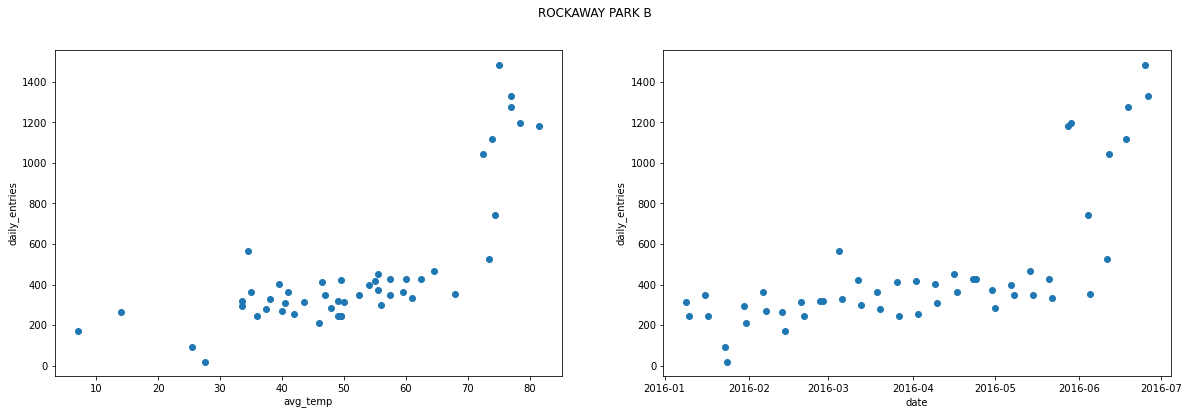

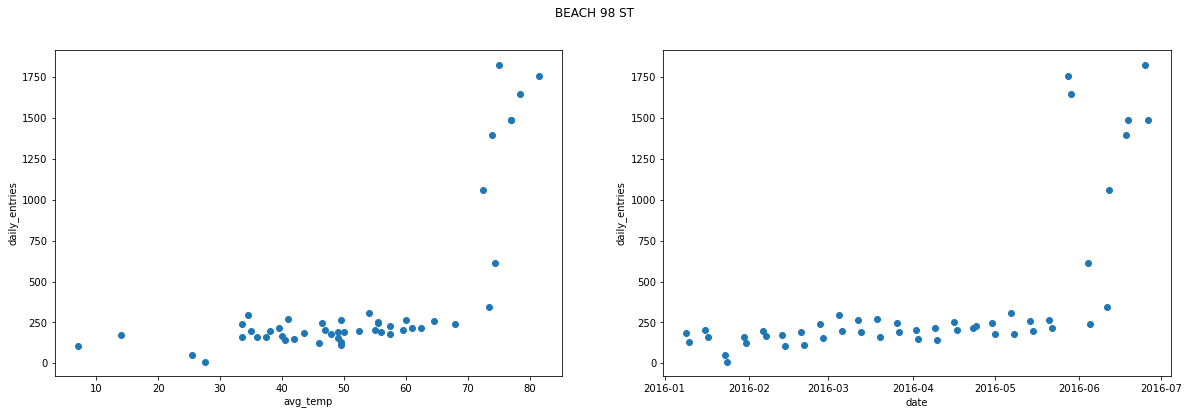

In [28]:
for station in stations_of_interest['station']:
    individual_station_df = weekend_turnstiles[weekend_turnstiles['station'] == station]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(station)
    
    ax1.scatter(individual_station_df['avg_temp'], individual_station_df['daily_entries'])
    ax1.set(xlabel = 'avg_temp', ylabel = 'daily_entries')
    
        
    ax2.scatter(individual_station_df['date'], individual_station_df['daily_entries'])
    ax2.set(xlabel = 'date', ylabel = 'daily_entries')
    
    plt.show()

## Graphing stations_of_interest and examining avg_temp and entries along with entries throughout the time period (now on the same chart)

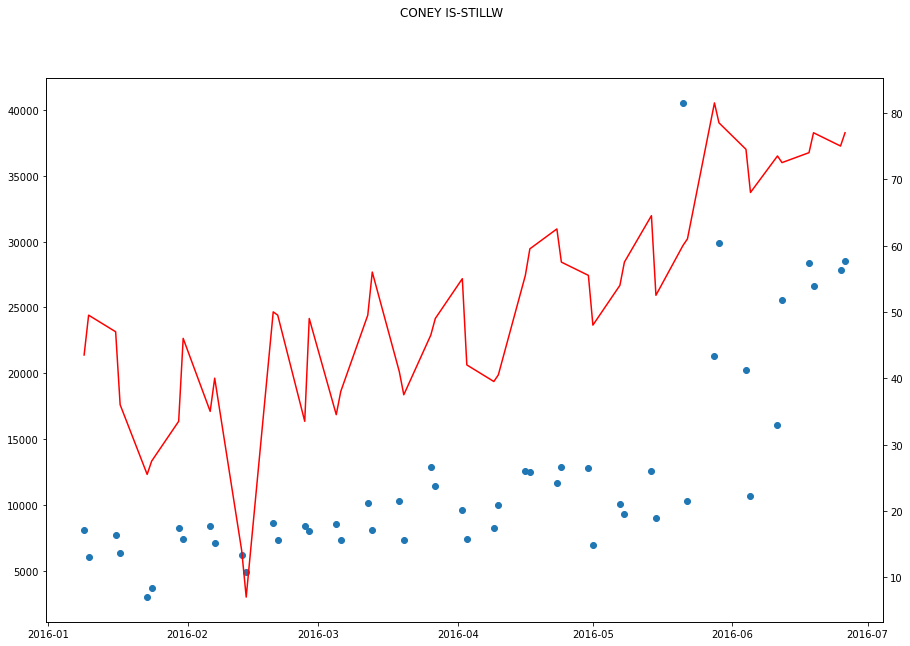

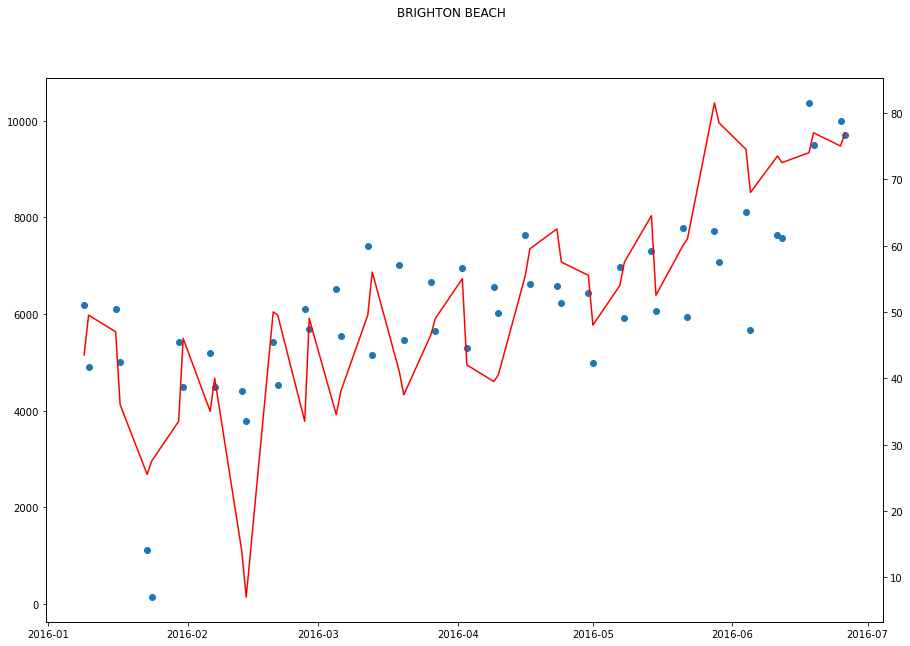

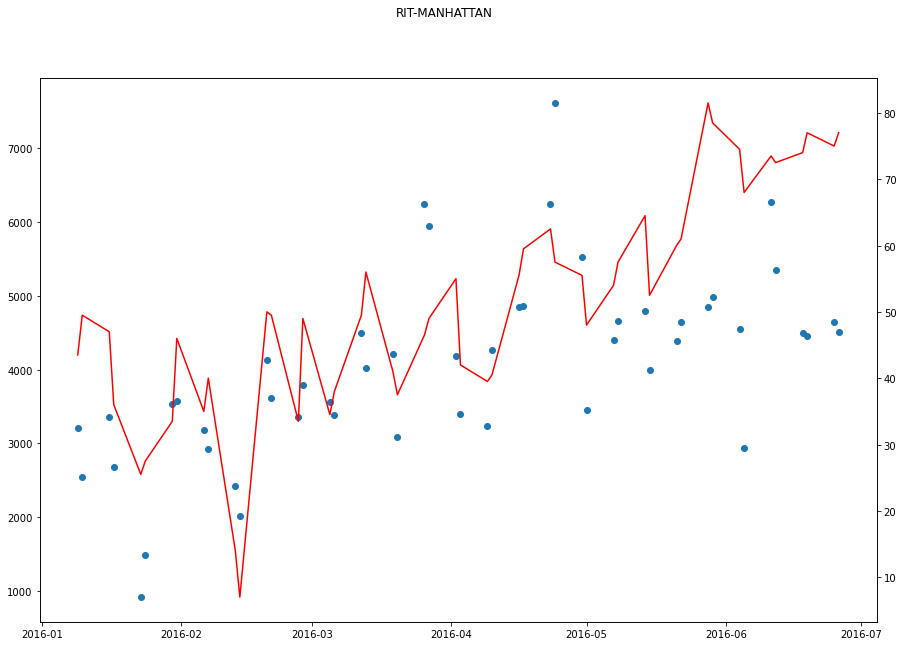

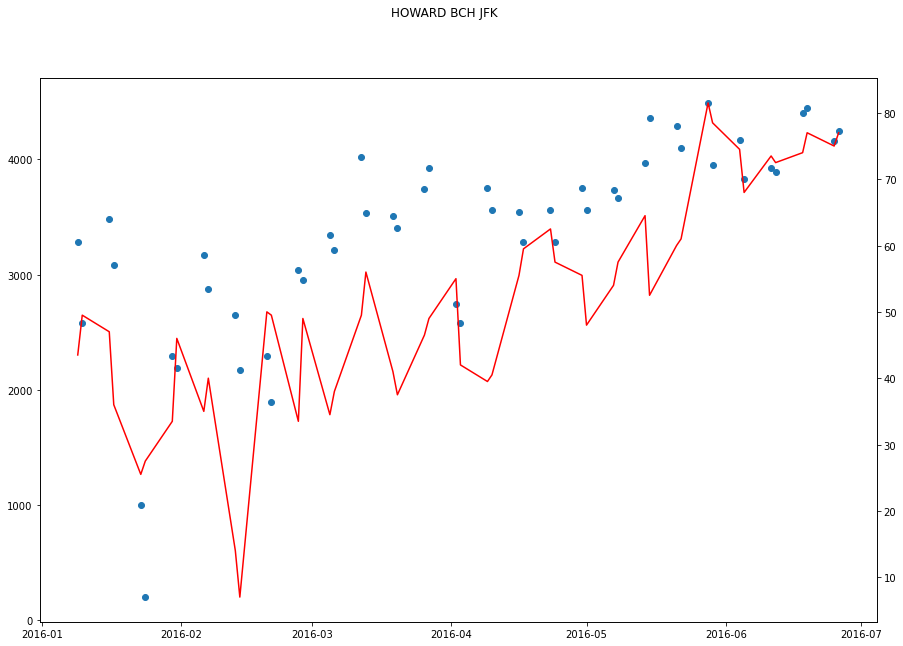

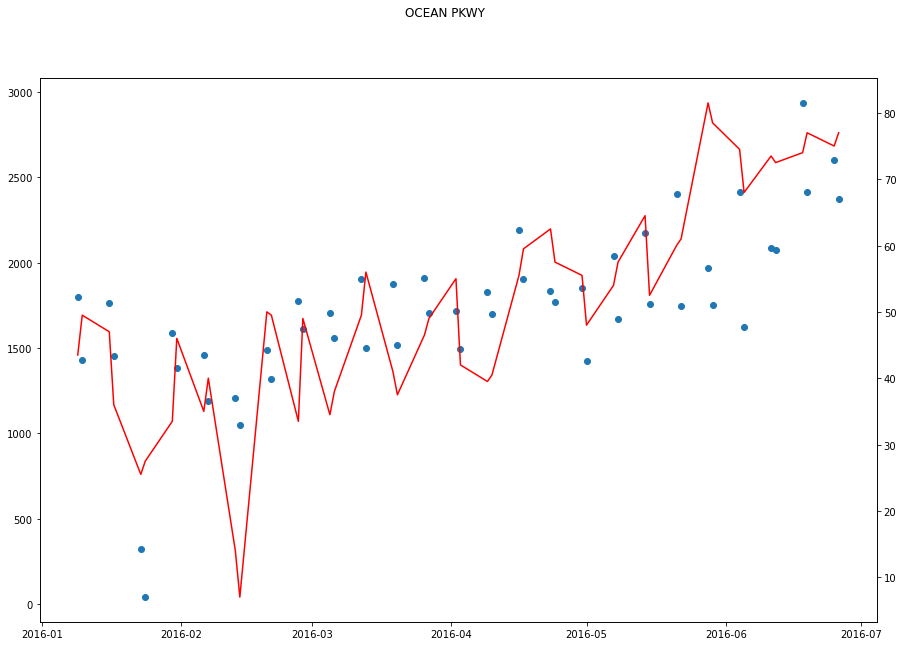

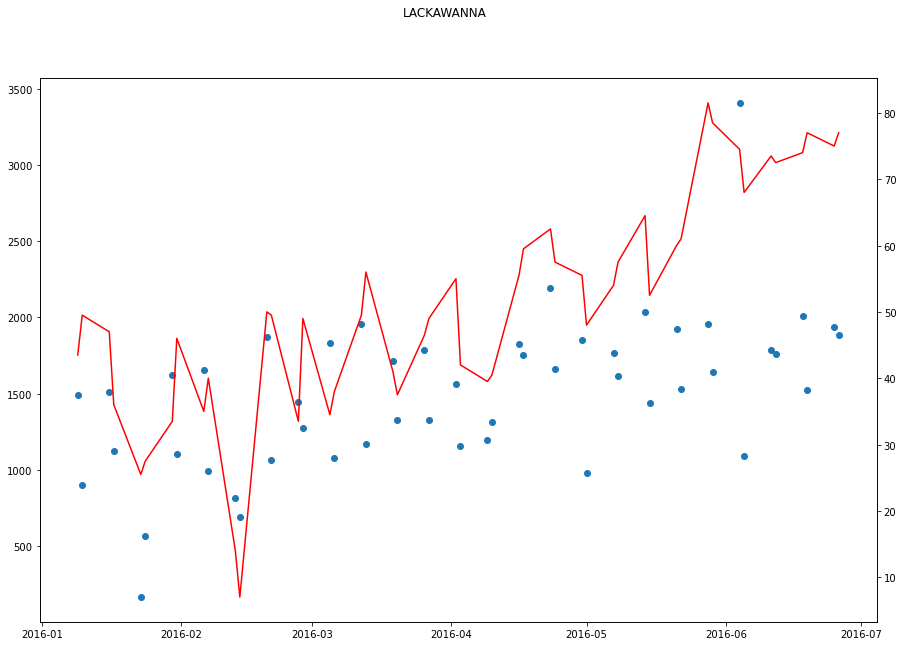

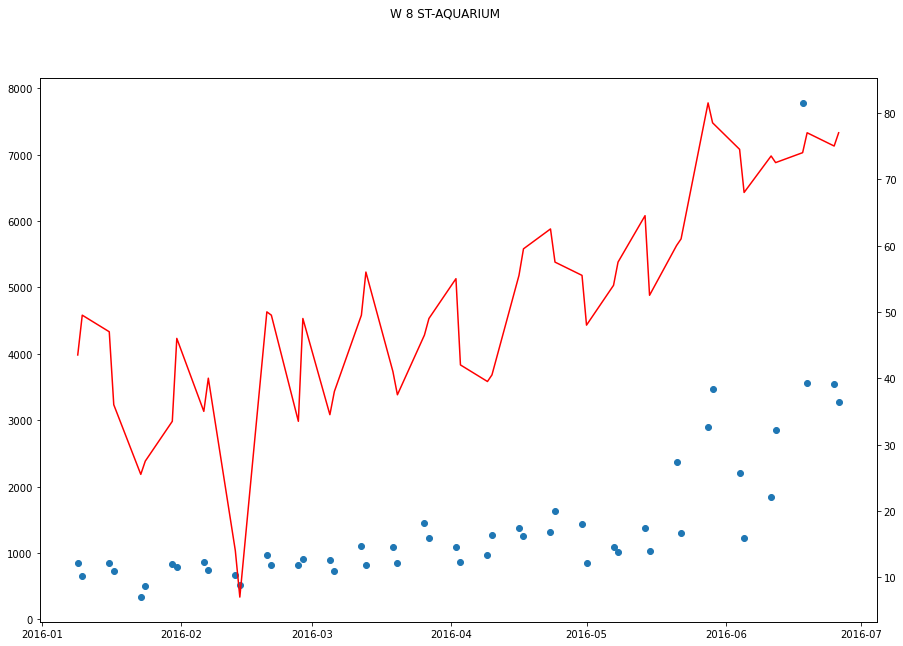

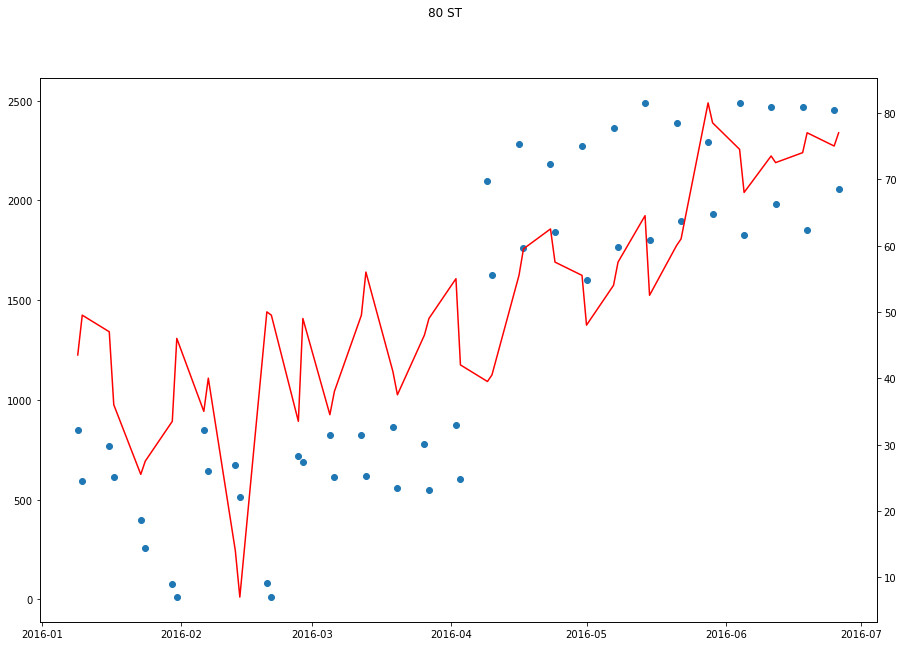

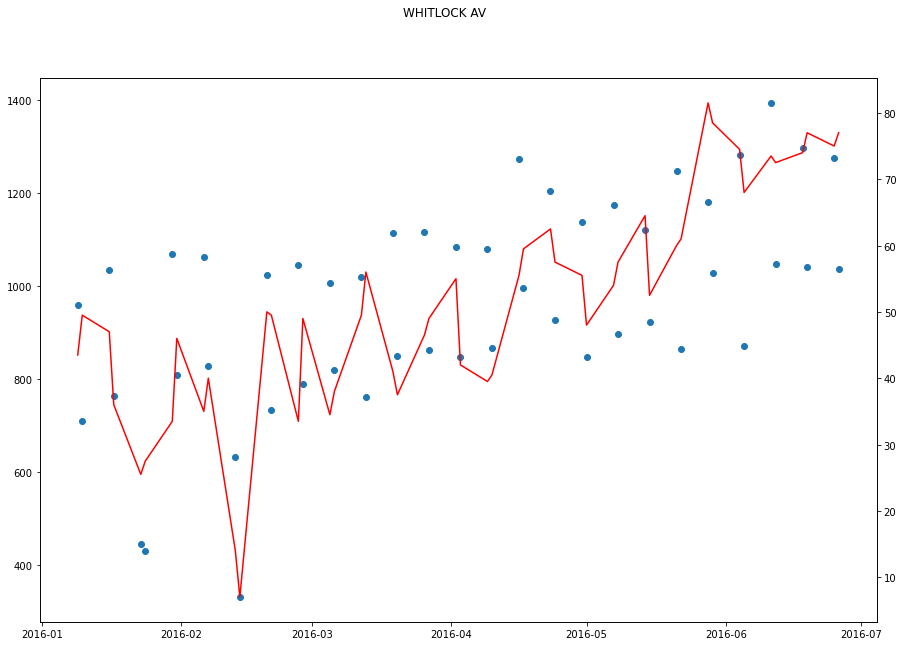

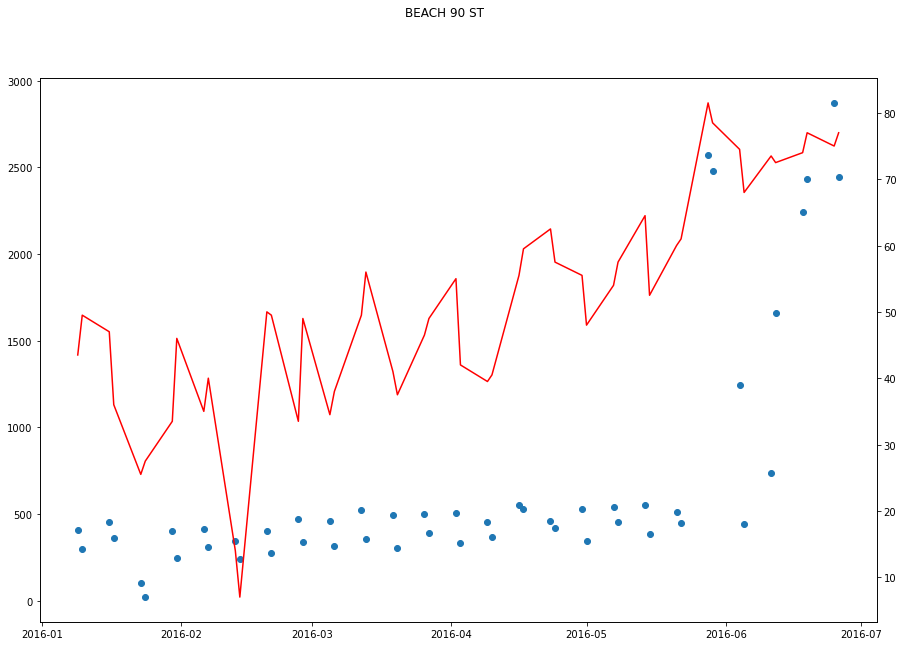

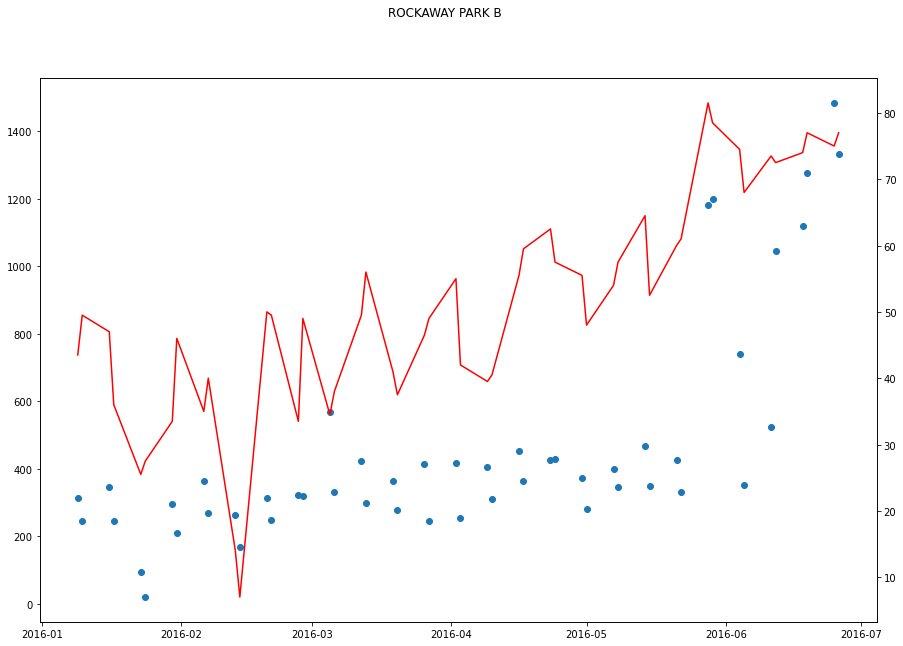

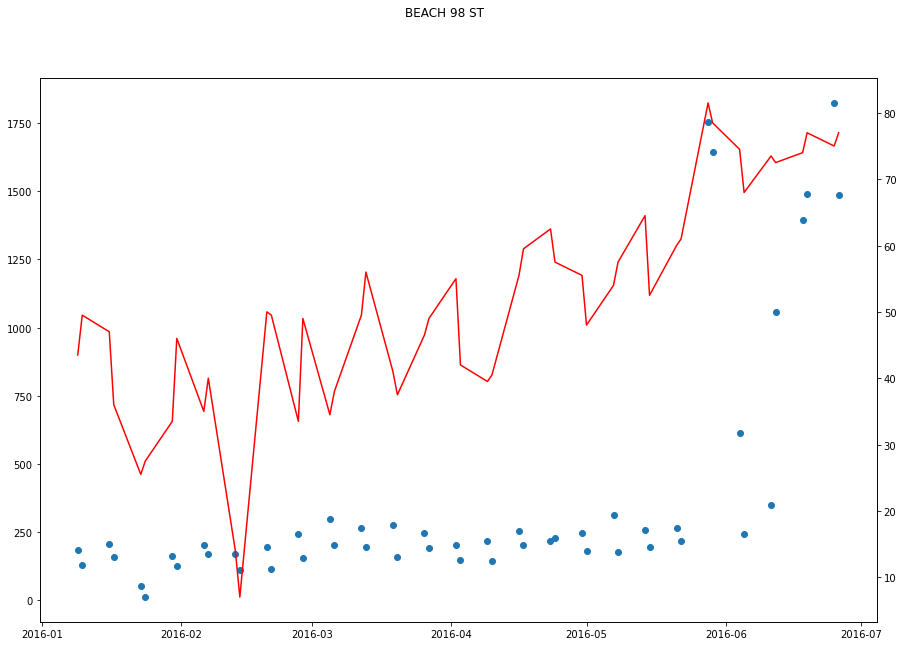

In [29]:
for station in stations_of_interest['station']:
    
    individual_station_df = weekend_turnstiles[weekend_turnstiles['station'] == station]
    
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()
    
    fig.suptitle(station)
    ax1.scatter(individual_station_df['date'], individual_station_df['daily_entries'])
    
    ax2.plot(individual_station_df['date'], individual_station_df['avg_temp'], color = 'red')
    
    plt.show()

No handles with labels found to put in legend.
<ipython-input-37-f8f7d5673eee>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels = individual_station_df['date'].dt.date, rotation = 80);
No handles with labels found to put in legend.
<ipython-input-37-f8f7d5673eee>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels = individual_station_df['date'].dt.date, rotation = 80);
No handles with labels found to put in legend.
<ipython-input-37-f8f7d5673eee>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels = individual_station_df['date'].dt.date, rotation = 80);
No handles with labels found to put in legend.
<ipython-input-37-f8f7d5673eee>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels = individual_station_df['date'].dt.date, rotation = 80);
No handl

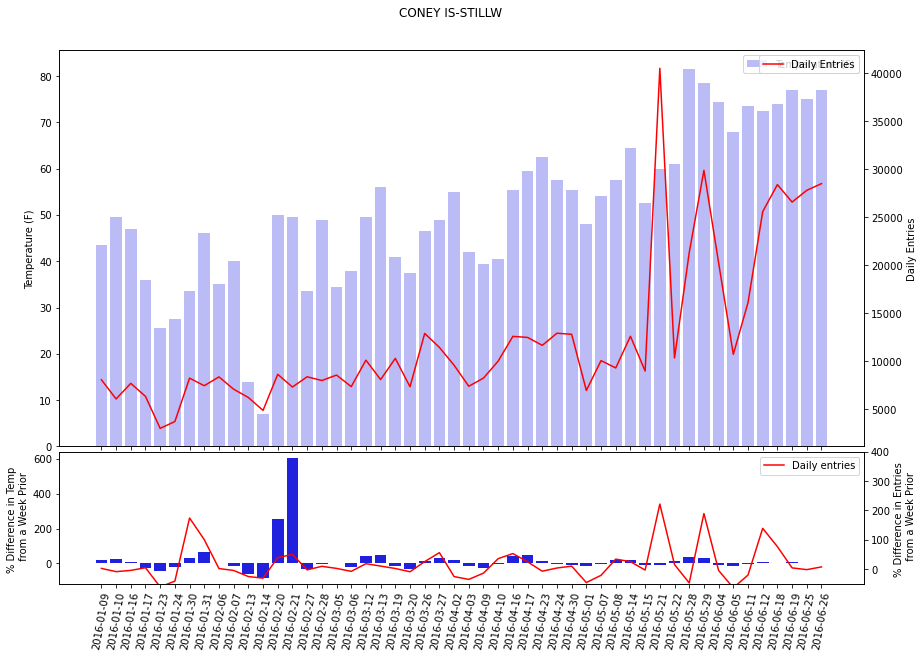

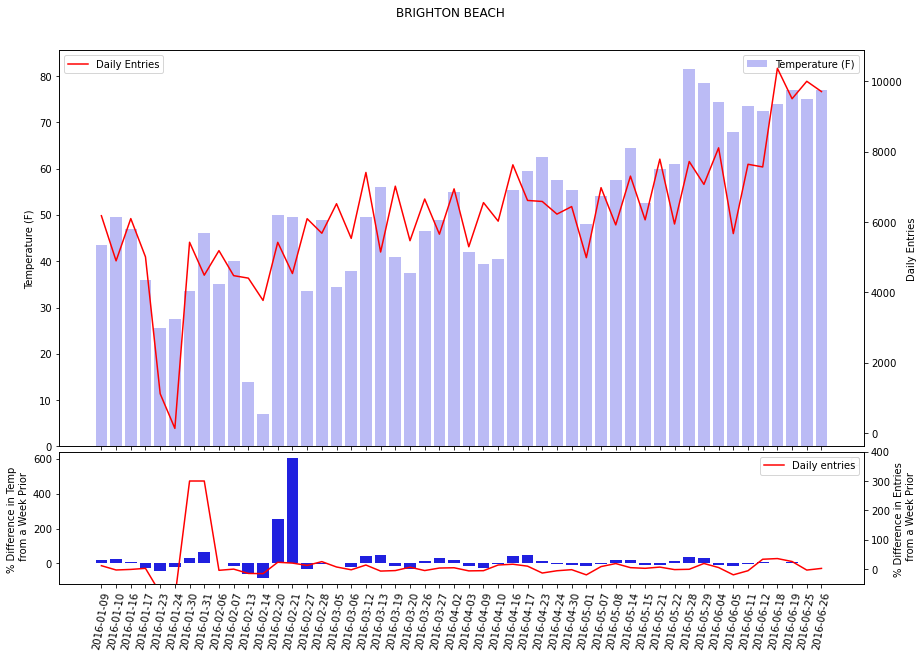

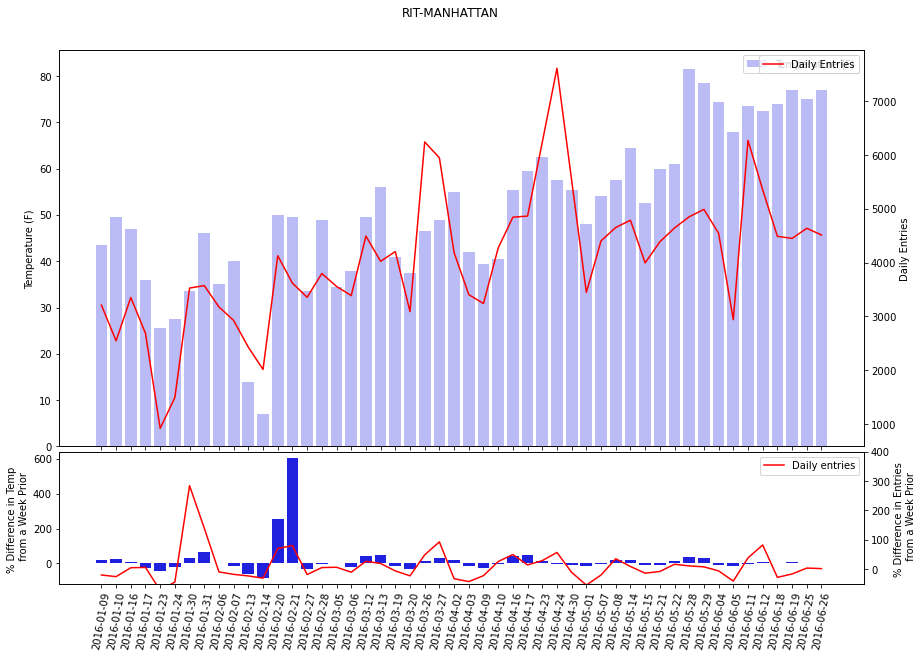

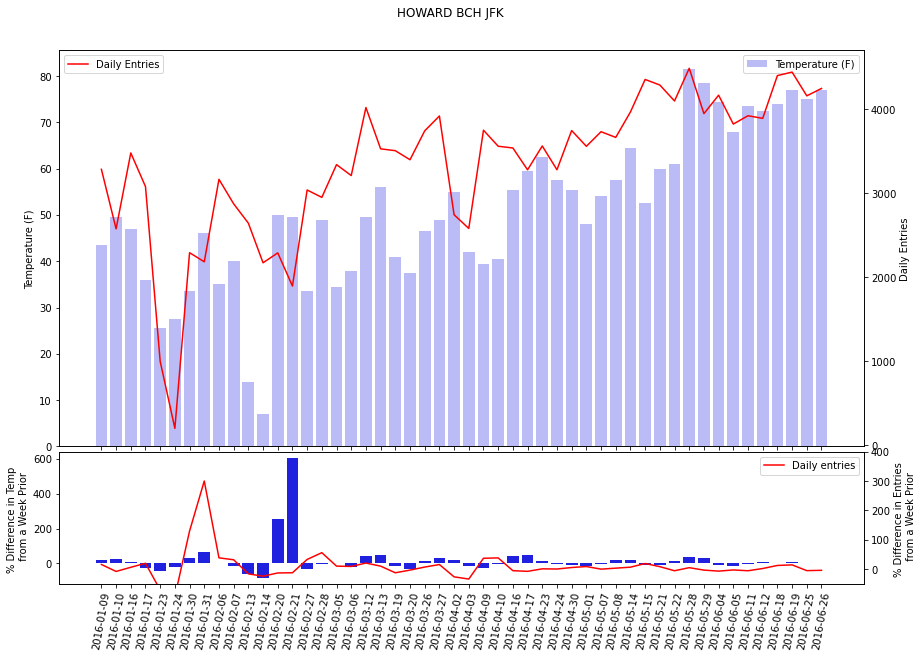

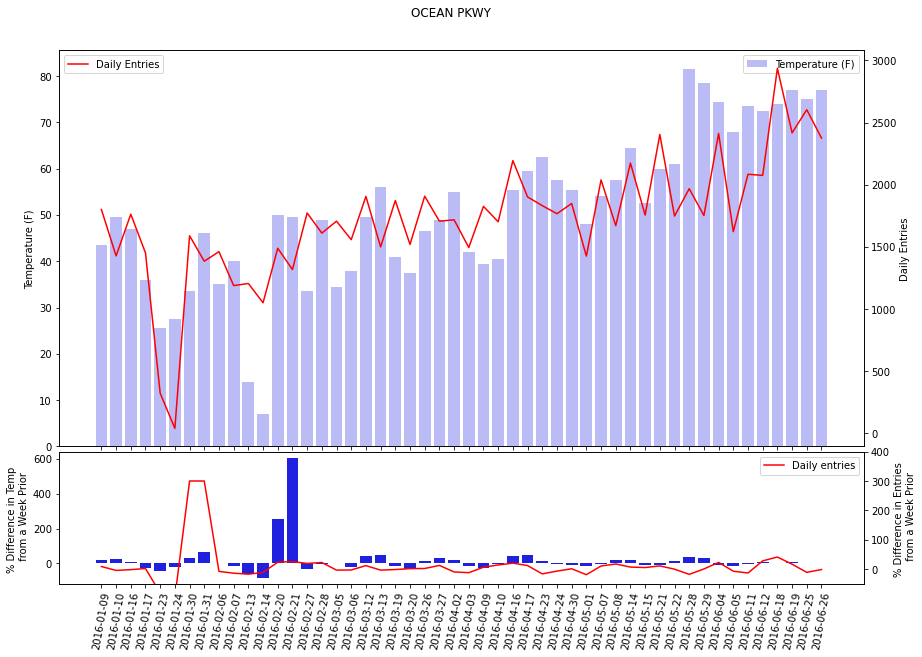

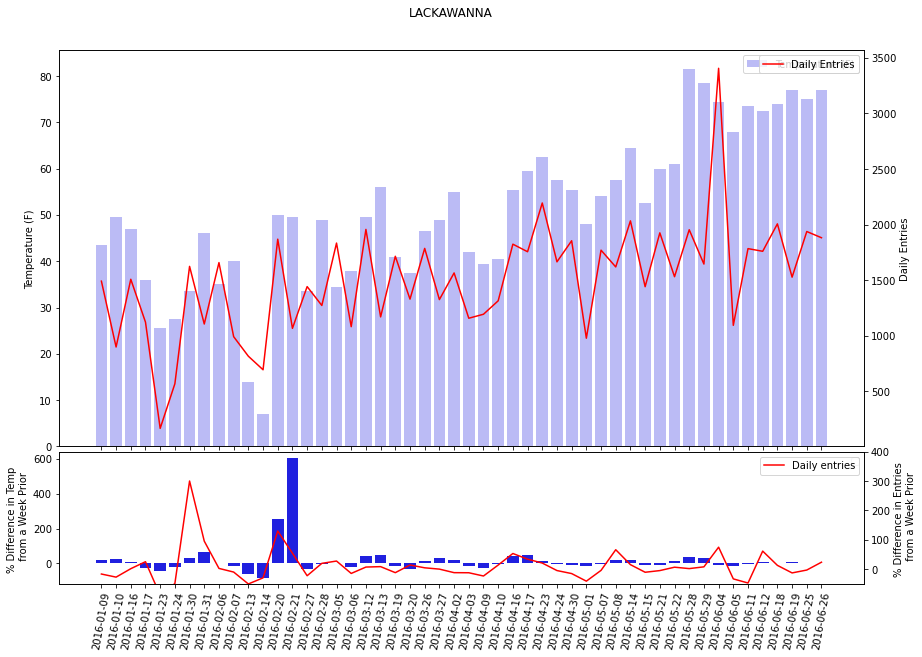

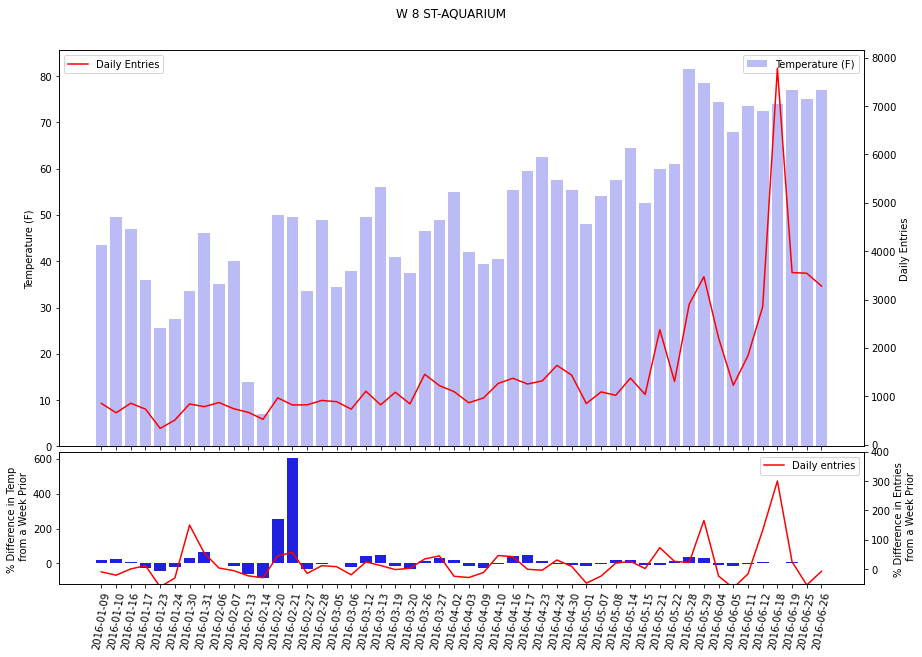

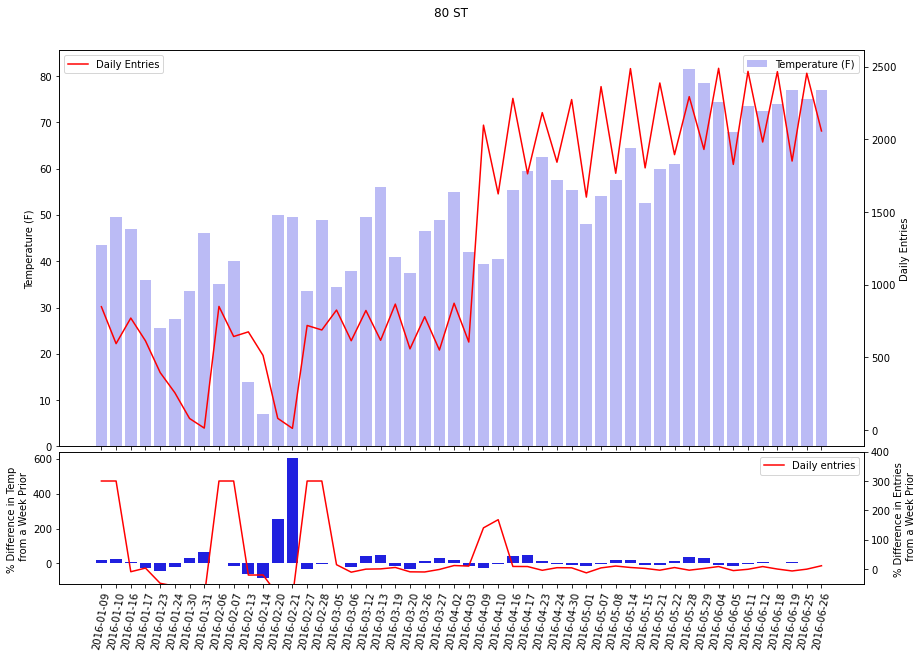

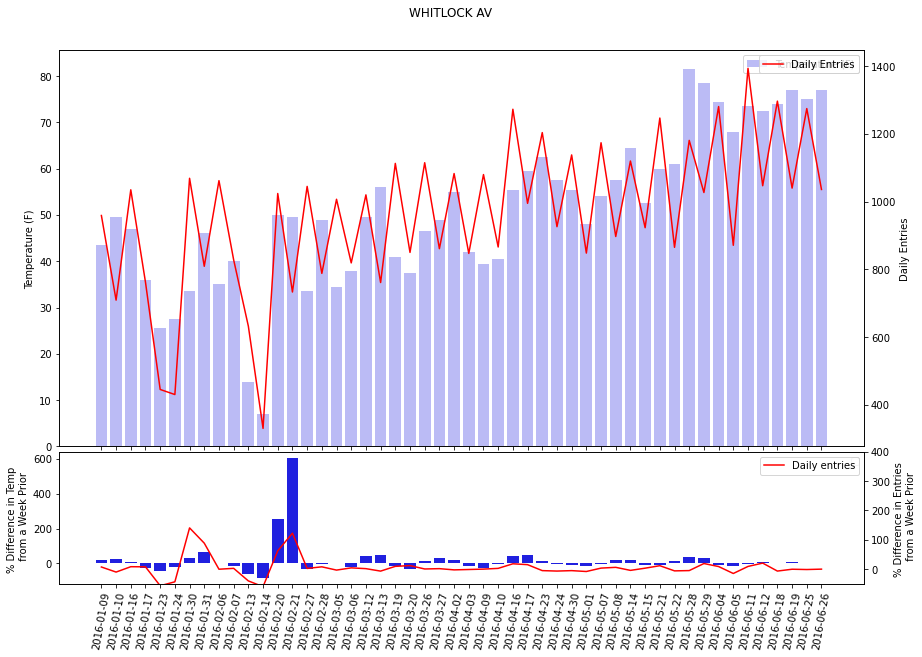

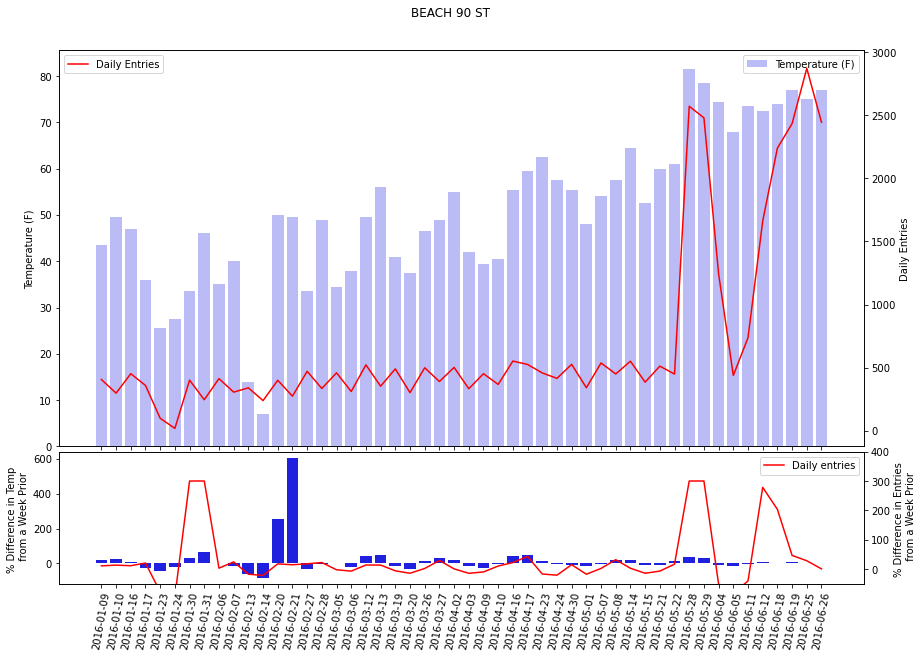

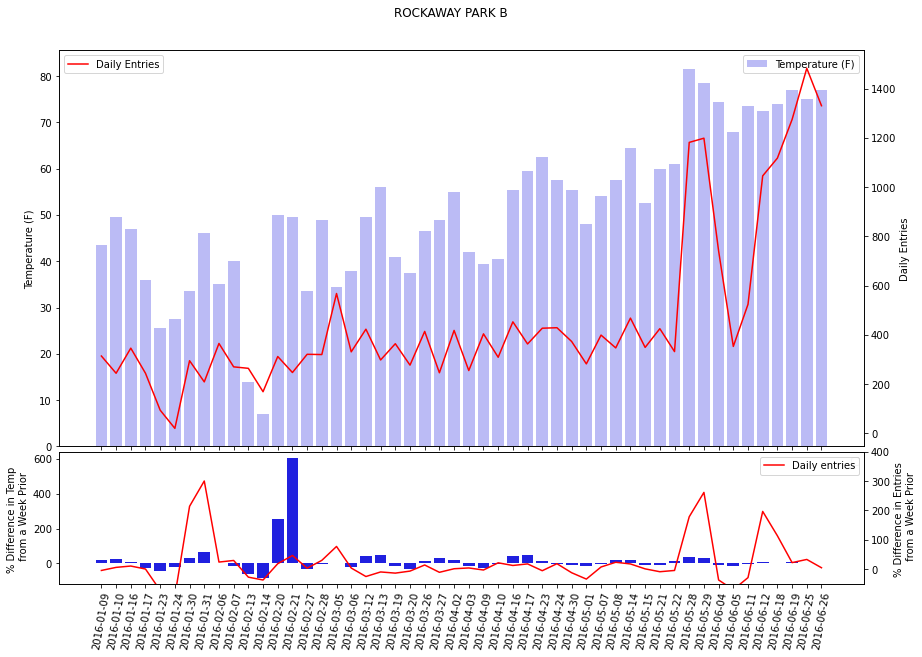

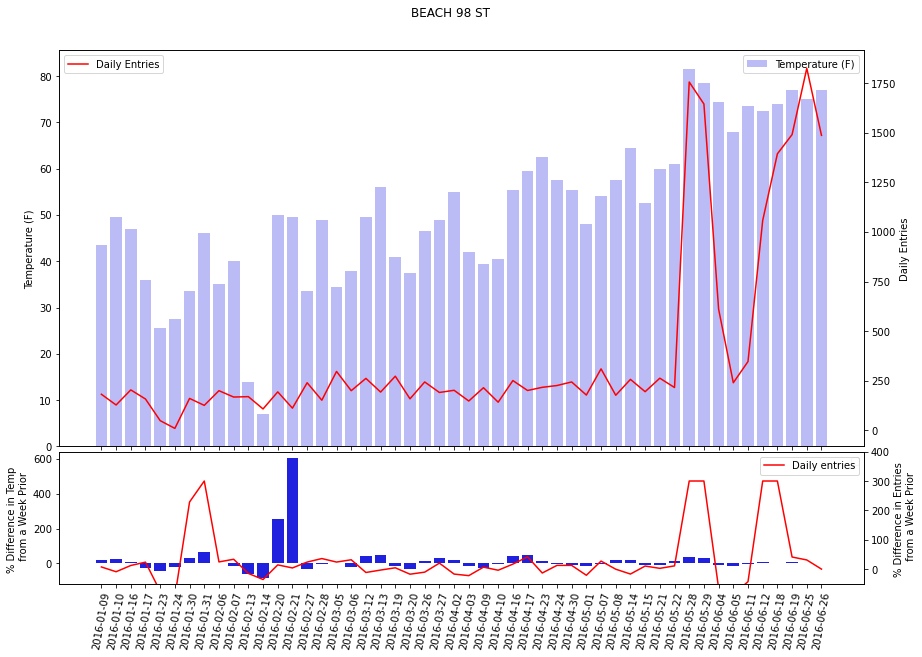

In [37]:
for station in stations_of_interest['station']:

    individual_station_df = weekend_turnstiles[weekend_turnstiles['station'] == station].copy()
    
    
    
    #There was a snow storm aon Jan 27 so the percent change is so large it is meaningless and
    #throws off the scale. Setting it to an arbitrarily high number.
    individual_station_df.loc[individual_station_df.week_pct_chg_entries > 300, 'week_pct_chg_entries'] = 300


    #initiate figure
    fig, axes = plt.subplots(2, 1, sharex = True, figsize = (12, 8), gridspec_kw={'height_ratios': [3, 1]})
    fig.tight_layout()
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=None, hspace=0.02)
    fig.suptitle(station, y = 1.05)


    #First series in the top chart (temperature bar plot)
    sns.barplot(ax = axes[0], x = individual_station_df['date'].astype(str),
                              y = individual_station_df['avg_temp'],
                              color = 'blue', alpha = 0.3, label = 'Temperature (F)')
    axes[0].set(xlabel = None, ylabel = 'Temperature (F)')

    #Making a second series twined on the top chart (entries line plot)
    ax2 = axes[0].twinx()
    sns.lineplot(ax = ax2, x = individual_station_df['date'].astype(str),
                               y = individual_station_df['daily_entries'],
                               color = 'red', label = 'Daily Entries')
    ax2.set(xlabel = None, ylabel = 'Daily Entries')

    #adding legend to top chart
    axes[0].legend(loc=0)


    #Bottom chart
    sns.barplot(ax = axes[1], x = individual_station_df['date'].astype(str),
                              y = individual_station_df['week_pct_chg_temp'],
                              color = 'blue')
    axes[1].set(xlabel = None, ylabel = '% Difference in Temp \n from a Week Prior',)

    #Second series for bottom chart (Percent change in entries since one week ago)
    ax3 = axes[1].twinx()
    sns.lineplot(ax = ax3, x = individual_station_df['date'].astype(str),
                               y = individual_station_df['week_pct_chg_entries'],
                               color = 'red', label = 'Daily entries')
    ax3.set(xlabel = None, ylabel = '% Difference in Entries \n from a Week Prior', ylim = (-50, 400))

    #adding legend to bottom chart
    axes[1].legend(loc=0)


    #Setting the x axis at the bottom to be the dates
    axes[1].set_xticklabels(labels = individual_station_df['date'].dt.date, rotation = 80);


<ipython-input-52-4b865283ac85>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels = individual_station_df['date'].dt.date, rotation = 80);
<ipython-input-52-4b865283ac85>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels = individual_station_df['date'].dt.date, rotation = 80);


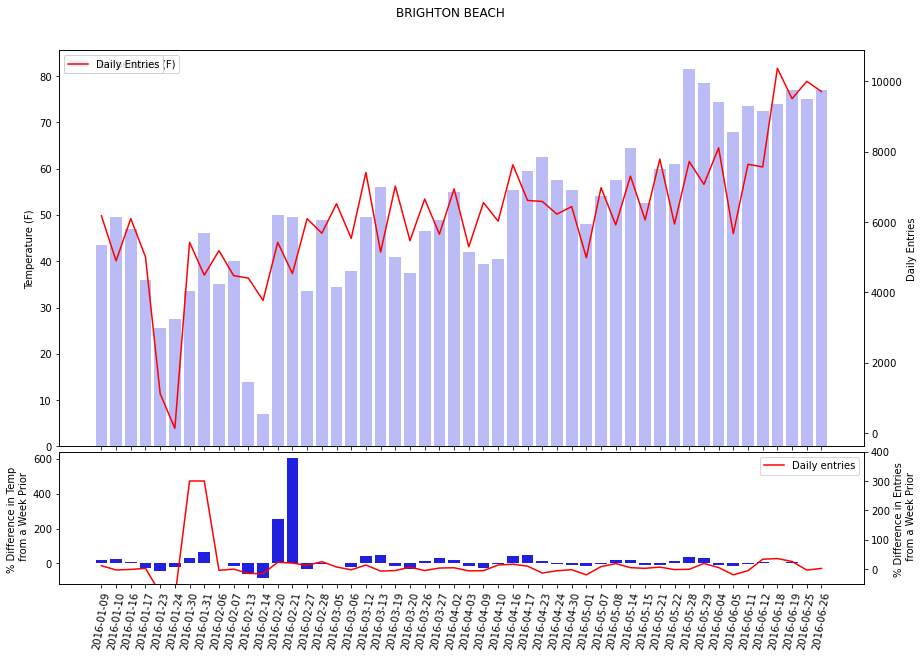

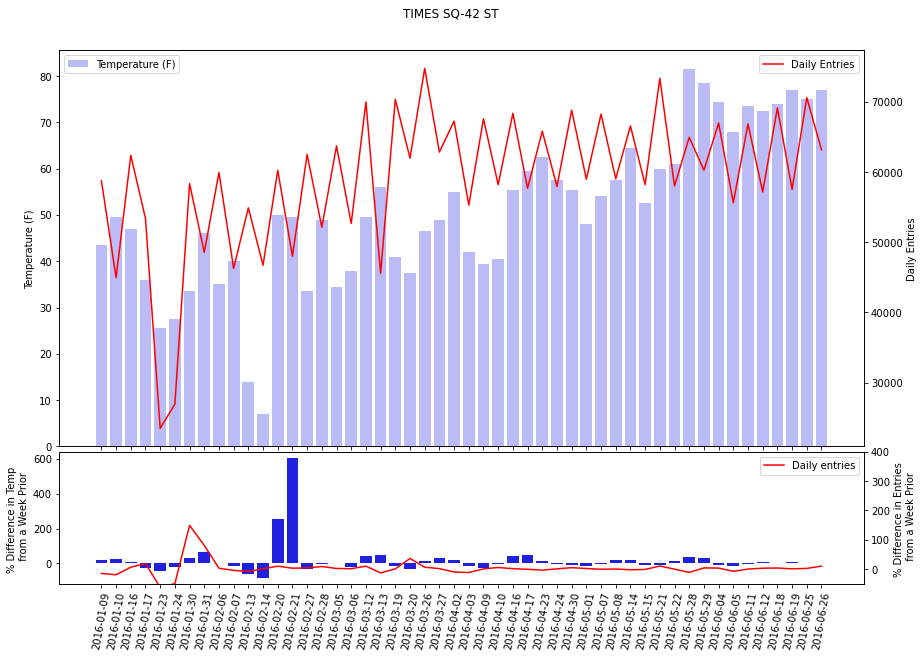

In [52]:
for station in ['BRIGHTON BEACH', 'TIMES SQ-42 ST']:

    individual_station_df = weekend_turnstiles[weekend_turnstiles['station'] == station].copy()
    
    
    
    #There was a snow storm aon Jan 27 so the percent change is so large it is meaningless and
    #throws off the scale. Setting it to an arbitrarily high number.
    individual_station_df.loc[individual_station_df.week_pct_chg_entries > 300, 'week_pct_chg_entries'] = 300


    #initiate figure
    fig, axes = plt.subplots(2, 1, sharex = True, figsize = (12, 8), gridspec_kw={'height_ratios': [3, 1]})
    fig.tight_layout()
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=None, hspace=0.02)
    fig.suptitle(station, y = 1.05)


    #First series in the top chart (temperature bar plot)
    sns.barplot(ax = axes[0], x = individual_station_df['date'].astype(str),
                              y = individual_station_df['avg_temp'],
                              color = 'blue', alpha = 0.3, label = 'Temperature (F)')
    axes[0].set(xlabel = None, ylabel = 'Temperature (F)')

    #Making a second series twined on the top chart (entries line plot)
    ax2 = axes[0].twinx()
    sns.lineplot(ax = ax2, x = individual_station_df['date'].astype(str),
                               y = individual_station_df['daily_entries'],
                               color = 'red', label = 'Daily Entries')
    ax2.set(xlabel = None, ylabel = 'Daily Entries')

    #adding legend to top chart
    axes[0].legend(loc=0)


    #Bottom chart
    sns.barplot(ax = axes[1], x = individual_station_df['date'].astype(str),
                              y = individual_station_df['week_pct_chg_temp'],
                              color = 'blue')
    axes[1].set(xlabel = None, ylabel = '% Difference in Temp \n from a Week Prior',)

    #Second series for bottom chart (Percent change in entries since one week ago)
    ax3 = axes[1].twinx()
    sns.lineplot(ax = ax3, x = individual_station_df['date'].astype(str),
                               y = individual_station_df['week_pct_chg_entries'],
                               color = 'red', label = 'Daily entries')
    ax3.set(xlabel = None, ylabel = '% Difference in Entries \n from a Week Prior', ylim = (-50, 400))

    #adding legend to bottom chart
    axes[0].legend(loc='upper left')

    #Setting the x axis at the bottom to be the dates
    axes[1].set_xticklabels(labels = individual_station_df['date'].dt.date, rotation = 80);


In [ ]:
all_data_weather.set_index('date').loc['02/13/2016':'02/28/2016']

In [31]:
mask = (weekend_turnstiles['station'].str.contains('42'))
weekend_turnstiles[mask]

,station,date,daily_entries,max_temp,min_temp,avg_temp,precipitation,snowfall,snow_depth,day_of_week,week_ago_temp,week_ago_entries,week_pct_chg_temp,week_pct_chg_entries
12199,42 ST-BRYANT PK,2016-01-09,16573.0,47,40,43.5,0.25,0.0,0.0,Saturday,36.0,17328.0,20.833333,-4.357110
12200,42 ST-BRYANT PK,2016-01-10,11090.0,59,40,49.5,1.80,0.0,0.0,Sunday,40.0,13346.0,23.750000,-16.903941
12206,42 ST-BRYANT PK,2016-01-16,14735.0,52,42,47.0,0.24,0.0,0.0,Saturday,43.5,16573.0,8.045977,-11.090328
12207,42 ST-BRYANT PK,2016-01-17,10888.0,42,30,36.0,0.05,0.4,0.0,Sunday,49.5,11090.0,-27.272727,-1.821461
12213,42 ST-BRYANT PK,2016-01-23,5291.0,27,24,25.5,2.31,27.3,6.0,Saturday,47.0,14735.0,-45.744681,-64.092297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63334,TIMES SQ-42 ST,2016-06-12,57163.0,83,62,72.5,0.00,0.0,0.0,Sunday,68.0,55629.0,6.617647,2.757555
63340,TIMES SQ-42 ST,2016-06-18,69149.0,87,61,74.0,0.00,0.0,0.0,Saturday,73.5,66862.0,0.680272,3.420478
63341,TIMES SQ-42 ST,2016-06-19,57531.0,88,66,77.0,0.00,0.0,0.0,Sunday,72.5,57163.0,6.206897,0.643773
63347,TIMES SQ-42 ST,2016-06-25,70609.0,86,64,75.0,0.00,0.0,0.0,Saturday,74.0,69149.0,1.351351,2.111383
